In [1]:
import numpy as np
import cv2
import skimage
import math
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from scipy import stats
from statistics import mean 
from collections import OrderedDict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

#Optional modules
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

In [2]:
#import watershed

In [7]:
img = cv2.imread('../../example_images/sem_1.jpg',0)

In [8]:
def boundary_detection(img, thres = 20):
        '''
        thres: threshold to distinguish the scale bar background with particle background by grey scale
        for now only work for SEM img, needs update if apply to different imgs
        scan from upper to bottom, also needs update if need scan from left to right
        
        img: input image in gray scale
        thres: threshold for contrast of distinguishing the boundary, i.e larger thres means higher contrast for boundary
        '''
        mode_list = []
        for line in range(len(img)):
            mode = stats.mode(img[line])
            mode_list.append(int(mode[0]))

            if line >= 1:
                mode_mean = mean(mode_list)
                if mode_mean - int(mode[0]) >= thres:
                    boundary = line
                    break

        return boundary

In [9]:
def corner_detection(img, actual_len):
    """
    This function is used to find the length of each pixel in nm.
    The unit of the output length_each_pixel is nm
    
    img: input image in gray scale
    actual_len: real length in micrometer
    """ 
    
    def dilated_image(img,sigma=1):
        """
        filtering regional maxima to find bright features by 
        using gaussian filter and reconstruction
        simga: standard deviation for Gaussian kernel 
        """
        # Convert to float: Important for subtraction later which won't work with uint8
        img = gaussian_filter(img, sigma)
        seed = np.copy(img, sigma)
        seed[1:-1, 1:-1] = img.min()
        mask = img

        dilated = reconstruction(seed, mask, method='dilation')
        return dilated
    
    
    
    
    actual_len = actual_len*1000
    height = img.shape[0]
    width = img.shape[1]
    #find the bottom part of the SEM image. Here we used the return refunction 
    ime = img[boundary_detection(dilated_image(img,1)): , : ]
    
    # find the smallest area of interest
    boundary_v = []
    thres = 100
    for i in range(ime.shape[1]):
        if ime[:,i][0] > thres:
            boundary_v.append(i)
    
    #determine the smaller one of the scale bar region
    ime = img[boundary_detection(dilated_image(img,1)): , boundary_v[-1]+10: ]
    
    boundary_h = []
    for i in range(ime.shape[0]):
        if ime[i,:][0] > thres:
            boundary_h.append(i)
    ime = img[boundary_detection(dilated_image(img,1)):boundary_detection(dilated_image(img,1))+boundary_h[0] , boundary_v[-1]+10: ]
    
    tform = AffineTransform()
    image = warp(ime,tform.inverse)
    coords = corner_peaks(corner_harris(image))
    coords_subpix = corner_subpix(image, coords)
    
    #get the length of the scale bar
    #length_scale_bar = abs(coords[0][1] - coords[1][1])
    
    scales = []
    threshold = 500
    for i in range(len(coords)):
        for j in range(len(coords)):
            if j <= i:
                continue
            else:
                if coords[i][0] == coords[j][0]:
                    scale = abs(coords[i][1] - coords[j][1])
                    if scale > threshold:
                        scales.append((coords[i][0],scale))
                    else:
                        continue
                else:
                    continue
    scalebar = []
    for i in range(len(scales)):
        n_count = 0
        for j in range(len(scales)):
            if scales[i][0] == scales[j][0]:
                n_count += 1
            else:
                continue
        if n_count == 1:
            scalebar.append(scales[i][1])
        else:
            continue
    
    for i in range(len(scalebar)):
        num = scalebar.count(scalebar[i])
        if num >= 2:
            final_scale = scalebar[i]
        else:
            continue
    
    #length of each pixel
    length_each_pixel = actual_len/final_scale
    
    # length of each pixel
    #length_each_pixel = actual_len/length_scale_bar
    
    
    #plot the figure with corner detected
#     fig, ax = plt.subplots(figsize=(15,15))
#     ax.imshow(image, cmap=plt.cm.gray)
#     ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
#             linestyle='None', markersize=6)
#     ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=10)
#     plt.show()
    return length_each_pixel

In [10]:
length_each_pixel = corner_detection(img, 1)

In [11]:
def img_pread(img, thres = 20, cut = True):
    '''
    Pretreatment for the picture to get a dilated and boundary cutted image
    
    img: input image in gray scale
    thres: threshold for contrast distinguishing the boundary
    cut: boolean value to set if the img be cutted
    '''
    #Pretreatment for the boundary detection
    image = img
    image = gaussian_filter(image, 1)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation')
    
    if cut == True:
        image = mask - dilated
        bound = boundary_detection(dilated)
        img_c = image[:bound,:]
        img_c = img_c.astype(np.uint8)
    else:
        img_c = image
    
    return img_c

In [12]:
img_filtered = img_pread(img)

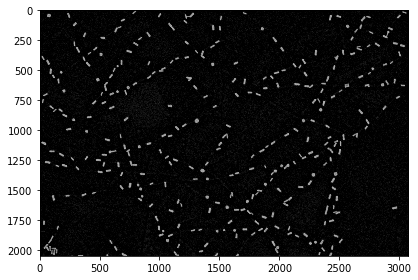

In [13]:
io.imshow(img_filtered)

In [14]:
def peri_avg(contours):
    '''
    Assistant function for determine the average perimeter from all contours
    
    contours: contours from the image
    '''
    peri_c_tot = 0
    for c in contours:
        peri_c_tot += cv2.arcLength(c, True)
    peri_avg = peri_c_tot / len(contours)

    return peri_avg

In [15]:
def contour_capture(img, 
                    noise_factor = 0.25,
                    thresh_method = cv2.THRESH_BINARY,
                    area_thresh = 300):
    '''
    The function captures the contours from the given imgs
    Returns contours
    
    img: input image in gray scale
    noise_factor: factor used to set threshold for the threshold function
    thresh_method: please refer to cv2.threshold
    area_thresh: threshold to ignore noise contours
    '''
    _, threshold = cv2.threshold(img, img.max() * noise_factor, img.max(), thresh_method)
    contours, _=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if cv2.contourArea(contour) >= area_thresh]
    
    return contours

In [16]:
contours = contour_capture(img_filtered)

In [17]:
def shape_radar(contours, img, thresh_di = 1.09, thres_poly = 1.75):
    '''
    Takes input from contour_capture
    return a annotated img from setted threshold
    Model tunning is possible by using different predictions provided below
    
    contours: contours from the image
    img: dilated image from previous function
    '''

    #Create plot, copy the img and convert into color scale
    plt.figure(figsize=(20,16))
    dilated_c = img.copy()
    dilated_c = cv2.cvtColor(dilated_c,cv2.COLOR_GRAY2RGB)
    avg_c = peri_avg(contours)
    
    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        #Optional predictors
        area = cv2.contourArea(c)
        len_c = round(cv2.arcLength(c, True), 1)
        r_area_len = round((area/len_c),1)
        r_peri = len_c / avg_c

        if r_peri <= thresh_di:
            cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif r_peri > thresh_di and r_peri <= thres_poly:
            if area > 900:
                cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3)
                cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
            else:
                cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif r_peri > thres_poly:
            cv2.putText(dilated_c, 'polymer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(0, 255, 0), 3) 
            cv2.drawContours(dilated_c, [box], 0, (0, 255, 0), 3)

    return dilated_c


In [18]:
img_shape = shape_radar(contours, img_filtered)

<Figure size 1440x1152 with 0 Axes>

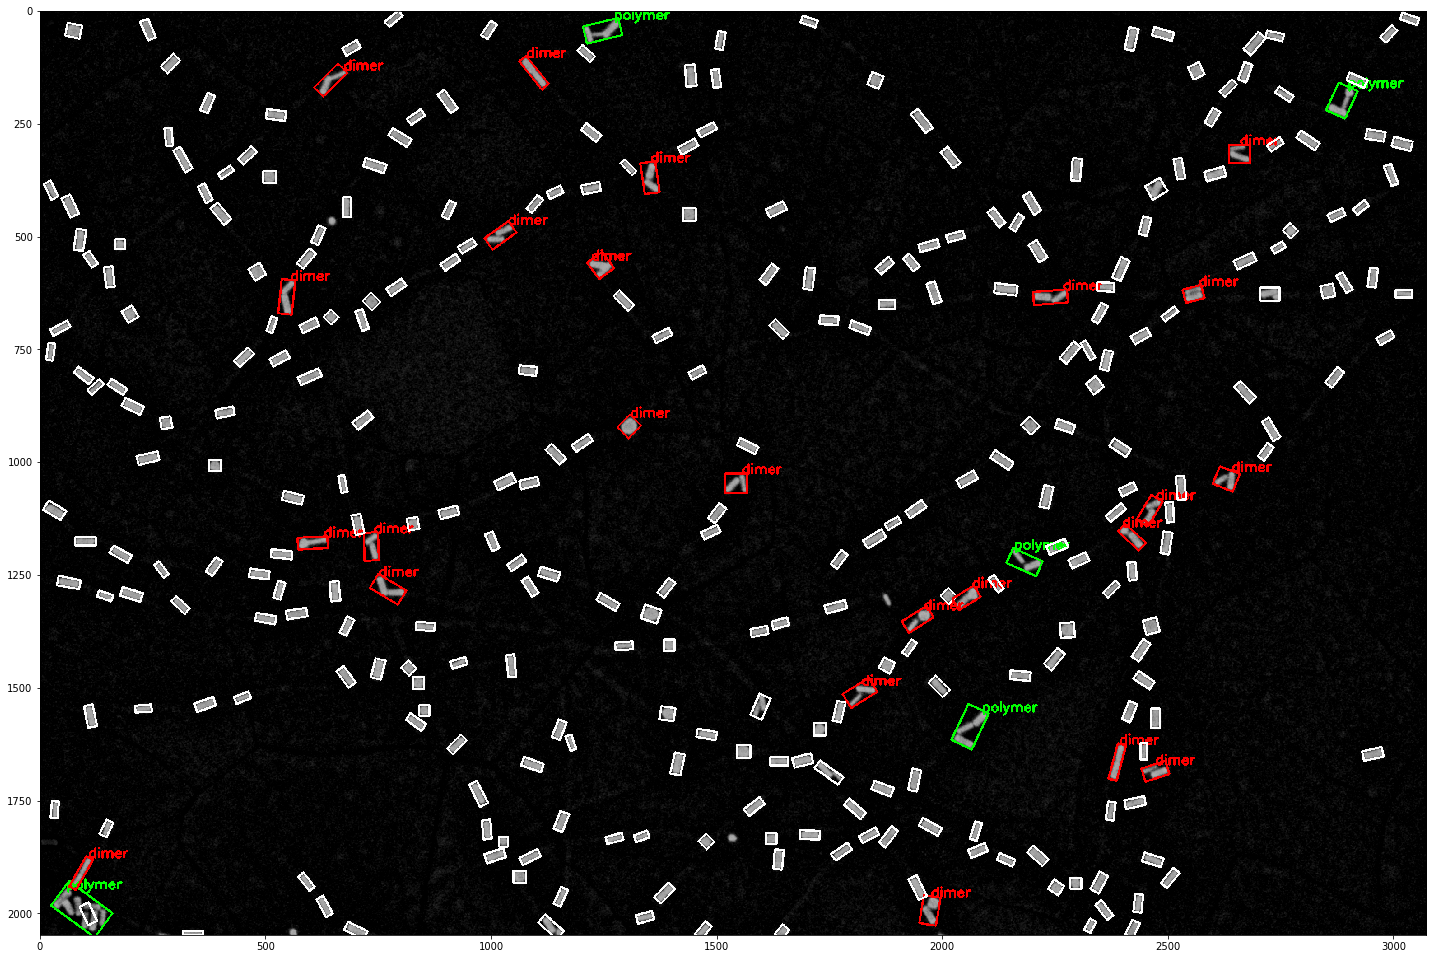

In [19]:
plt.figure(figsize=(20,16))
io.imshow(img_shape)

# Adapted from partycool_my


## Plotly_trail: https://plot.ly/python/histograms/

In [20]:
def partycool_summary(contours, convert_factor = 0, enable_poly = True, thresh_di = 1.09, thres_poly = 1.75, spherical= False ):
    '''
    returns a dataframe that summarized the particle information
    '''
    
    if enable_poly == True:
        contours = contours
    elif enable_poly == False:
        avg_c = peri_avg(contours)
        contours = [contour for contour in contours if (cv2.arcLength(contour, True) / avg_c) <= thresh_di]
    
    
    
    loc_x = []
    loc_y = []
    aspect_r = []
    area_l = []
    arealen_r = []
    category_l = []
    cX_au=[]
    cY_au=[]
    height = []
    width = []
    com_arr = np.empty((0, 2))
    angles = []
    
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        area = cv2.contourArea(c)
        avg_c = peri_avg(contours)
        len_c = round(cv2.arcLength(c, True), 1)
        r_peri = len_c / avg_c
        # center of mass of each particle
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY= int(M["m01"] / M["m00"])
        else:
          # set values as what you need in the situation
            cX, cY = 1,1  
        
        #particle arientation
             
        try:
            (com), _, angle = cv2.fitEllipse(c)
        except:
            continue
        com = np.array(com)
        com_arr = np.append(com_arr, [com], axis=0)
        angles.append(int(angle))
    
        
        category = ''

        if r_peri <= thresh_di:
            category = 'monomer'
        elif r_peri > thresh_di and r_peri <= thres_poly:
            if area > 900:
                category = 'dimer'
            else:
                category = 'monomer'
        elif r_peri > thres_poly:
            category = 'polymer'

        loc_x.append(x)
        loc_y.append(y)
        aspect_r.append(float('%.2g' % aspect_ratio))
        area_l.append(int(area))
        category_l.append(category)
        cX_au.append(cX)
        cY_au.append(cY)
        height.append(w)
        width.append(h)
    
    #aspact ratio correction
    aspect_ratio = []
    for i in range(len(aspect_r)):
        if aspect_r[i] < 1:
            aspect_ratio.append(1/aspect_r[i])
        else:
            aspect_ratio.append(aspect_r[i])
    #Radius calculation
    #Conversion part
    if convert_factor != 0:
        area_list = [int(a * (convert_factor ** 2)) for a in area_l]
        height_list = [int(a*convert_factor) for a in width]
        width_list = [int(a*convert_factor) for a in height]
        #Radius calculation
        r = [int(math.sqrt(a/math.pi)) for a in area_list]
    elif convert_factor == 0:
        area_list = [int(a) for a in area_l]
        height_list = [int(a) for a in width]
        width_list = [int(a) for a in height]
        r = [int(math.sqrt(a/math.pi)) for a in area_list]
        
    if spherical==True:
        result_dict = {'Cx' : cX_au, 
                       'Cy' : cY_au,
                       'Area (nm\u00b2)' : area_list,
                       'Radius (nm)' : r,
                       'Category' : category_l}
    elif spherical==False:
          result_dict = {'Cx' : cX_au, 
                         'Cy' : cY_au,
                         'Height (nm)' : width_list,
                         'Width (nm)' : height_list,
                         'Aspect Ratio' : aspect_ratio,
                         'Area (nm\u00b2)' : area_list,
                         'Angles (°)' :angles,
                         'Category' : category_l}
                     #change the 'Area (nm\u00b2)' to area_list        
                
    result_df = pd.DataFrame.from_dict(result_dict)
    
    return result_df


In [21]:
df = partycool_summary(contours, convert_factor = 1.2, enable_poly = True, thresh_di = 1.09, thres_poly = 1.75, spherical=False )

In [22]:
df.head()

,Cx,Cy,Height (nm),Width (nm),Aspect Ratio,Area (nm²),Angles (°),Category
0,337,2043,55,12,4.6,488,91,monomer
1,1644,2038,34,25,1.4,524,38,monomer
2,1469,2036,38,31,1.2,652,43,monomer
3,698,2036,54,33,1.6,1019,115,monomer
4,2420,2033,37,36,1.0,761,29,monomer


In [30]:
def partycool_plots(df, interactive = False):
    '''
    dataframe: df from partycool_summary
    interactive: define whether the plots be interactive
    '''
    if interactive == False:
        plt.rc('xtick', labelsize = 16)
        plt.rc('xtick.major', pad = 15)
        plt.rc('ytick', labelsize = 20)
        plt.rc('lines', lw = 2.2, markersize = 7.5)
        plt.rc('legend', fontsize = 16)
        plt.rc('axes', linewidth=2.2)
        
        data = [[df['Angles (°)'],df['Aspect Ratio']],[df['Height (nm)'],df['Width (nm)']]]
        bins = 40
        colors = [['purple','darkorange'], ['mediumturquoise', 'lightgreen']]
        xlabels = [['Angles (°)','Aspect Ratio'],['Height (nm)','Width (nm)',]]
        ylabel = 'Count'
        fig, ax = plt.subplots(2, 2, figsize=(16, 12))
        for i in range(2):
            for j in range(2):
                ax[i][j].hist(data[i][j], bins=bins, color=colors[i][j])
                ax[i][j].set_xlabel(xlabels[i][j], fontsize = 18)
                ax[i][j].set_ylabel(ylabel, fontsize = 18)
                ax[i][j].grid(True)
        plt.tight_layout()
        
    elif interactive == True:
        fig = make_subplots(rows=2, cols=2)
        subplot_titles = ['Area', 'Aspect Ratio', 'Height', 'Width']
        xaxis_title=['Angles','Aspect Ratio','Height (nm)', 'Width (nm)']
        yaxis_title='count'
        rows = 2
        cols = 2
        trace = [go.Histogram(x=df['Angles (°)'], marker_color='#800080',opacity=0.75),\
                 go.Histogram( x=df['Aspect Ratio'],opacity=0.75),\
                go.Histogram(x=df['Height (nm)'],opacity=0.75),go.Histogram(x=df['Width (nm)'],opacity=0.75)]

        for i, col in enumerate(subplot_titles):
            r = int(np.ceil(((i+1)/cols)))
            c = i%2+1
            fig.add_trace(trace[i], row=r, col=c)
            fig.update_xaxes(title_text=xaxis_title[i], row=r, col=c)
            fig.update_yaxes(title_text=yaxis_title, row=r, col=c)
            fig.update_layout(bargap=0.15,showlegend=False) 
        fig.show()
    
    #pie chart
    count_mono = 0
    count_di = 0
    count_poly = 0
    for i in range(len(df['Category'])):
        if df['Category'][i] =='monomer':
            count_mono +=1
        elif df['Category'][i] =='dimer':
            count_di += 1
        elif df['Category'][i] =='polymer':
            count_poly += 1
    colors = ['gold', 'darkorange', 'lightgreen']
    fig = go.Figure(data=[go.Pie(labels=['Monomer','Dimer','Polymer'],
                                 values=[count_mono, count_di, count_poly],title='Categories')])
    fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=14,
                      marker=dict(colors=colors, line=dict(color='#000000', width=2)))
    fig.show()
    
    return

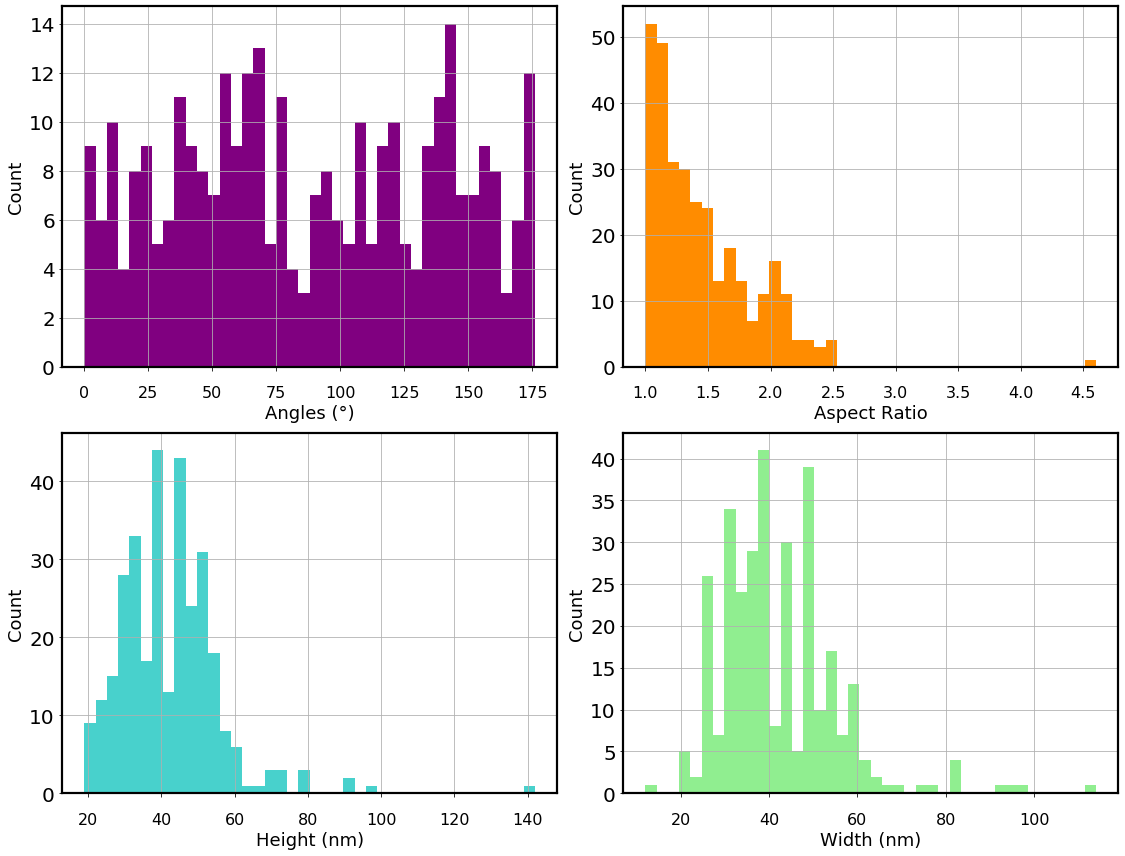

In [31]:
partycool_plots(df, False)

In [32]:
partycool_plots(df, True)

In [25]:
# def partycool_plots(dataframe, aspect, interactive = False):
#     '''
#     dataframe: df from partycool_summary
#     aspect: what user want to see
#     interactive: define whether the plots be interactive
#     '''
#     if aspect == 'area':
#         area = dataframe['Area (nm\u00b2)']
#         if interactive == False:
#             plt.figure(figsize=(8, 6))
#             _ = plt.hist(areas, bins=40, color='gray')
#             plt.xlabel('Area of Nanoparticles (nm\u00b2)', fontsize=16)
#             plt.ylabel('Count', fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             print("Total # of Au Particles :\n", len(areas))
#         elif interactive == True:
#             fig = go.Figure()
#             fig.add_trace(go.Histogram(x=area))
#             # fig.add_trace(go.Histogram(x=x1, name = 'width'))

#             # Overlay both histograms
#             fig.update_layout(
#                title_text='Particle area distribution', # title of plot
#                 xaxis_title_text='Area (nm\u00b2)', # xaxis label
#                 yaxis_title_text='Count', # yaxis label
#                 bargap=0.15, # gap between bars of adjacent location coordinates
#                 )
#             # Reduce opacity to see both histograms
#             fig.update_traces(opacity=0.75)
#             fig.show()
#     elif aspect == 'aspect_ratio':
#         aspectratio = dataframe['Aspect Ratio']
#         if interactive == False:
#             plt.figure(figsize=(8, 6))
#             _ = plt.hist(aspectratio, bins=40, color='gray')
#             plt.xlabel('Aspect Ratio of Nanoparticles', fontsize=16)
#             plt.ylabel('Count', fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             print("Total # of Au Particles :\n", len(aspectratio))
#         elif interactive == True:
#             fig = go.Figure()
#             fig.add_trace(go.Histogram(
#                 x=aspectratio,
#                 xbins=dict(
#                     start=0,
#                     end=2.5,
#                     size=0.1
#                 ),
#                 marker_color='#800080',
#                 opacity=0.75
#             )) 
#             # can add histnorm='percent' into go.Histogram and the y axis would be percentage

#             fig.update_layout(
#                 title_text='Aspect Ratio', # title of plot
#                 xaxis_title_text='Aspect ratio', # xaxis label
#                 yaxis_title_text='Counts', # yaxis label
#                 bargap=0.15, # gap between bars of adjacent location coordinates
#             )
#             fig.show()
#     elif aspect == 'height':
#         height = dataframe['Height (nm)']
#         if interactive == False:
#             plt.figure(figsize=(8, 6))
#             _ = plt.hist(height, bins=40, color='gray')
#             plt.xlabel('Particle hight distribution (nm)', fontsize=16)
#             plt.ylabel('Count', fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             print("Total # of Au Particles :\n", len(height))
#         elif interactive == True:
#             fig = go.Figure()
#             fig.add_trace(go.Histogram(x=height))
#             fig.update_layout(
#                title_text='Particle length distribution', # title of plot
#                 xaxis_title_text='Length (nm)', # xaxis label
#                 yaxis_title_text='Counts', # yaxis label
#                 bargap=0.15, # gap between bars of adjacent location coordinates
#                 )
#             # Reduce opacity to see both histograms
#             fig.update_traces(opacity=0.75)
#             fig.show()
#     elif aspect == 'width':
#         width = dataframe['Width (nm)']
#         if interactive == False:
#             plt.figure(figsize=(8, 6))
#             _ = plt.hist(width, bins=40, color='gray')
#             plt.xlabel('Particle width distribution (nm)', fontsize=16)
#             plt.ylabel('Count', fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             print("Total # of Au Particles :\n", len(height))
#         elif interactive == True:
#             fig = go.Figure()
#             fig.add_trace(go.Histogram(x=width))
#             fig.update_layout(
#                title_text='Particle width distribution', # title of plot
#                 xaxis_title_text='Length (nm)', # xaxis label
#                 yaxis_title_text='Count', # yaxis label
#                 bargap=0.15, # gap between bars of adjacent location coordinates
#                 )
#             # Reduce opacity to see both histograms
#             fig.update_traces(opacity=0.75)
#             fig.show()
#     elif aspect == 'angles':
#         angles = dataframe['Angles (°)']
#         if interactive == False:
#             plt.figure(figsize=(8, 6))
#             _ = plt.hist(angles, bins=40, color='gray')
#             plt.xlabel('Particle angle distribution (°)', fontsize=16)
#             plt.ylabel('Count', fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             print("Total # of Au Particles :\n", len(height))
#         elif interactive == True:
#             fig = go.Figure()
#             fig.add_trace(go.Histogram(x=angles))
#             fig.update_layout(
#                title_text='Particle angle distribution (°)', # title of plot
#                 xaxis_title_text='Angle (°)', # xaxis label
#                 yaxis_title_text='Count', # yaxis label
#                 bargap=0.15, # gap between bars of adjacent location coordinates
#                 )
#             # Reduce opacity to see both histograms
#             fig.update_traces(opacity=0.75)
#             fig.show()
#     return

# Plotly interactive plots

In [ ]:
#Example of plotly

areas = [cv2.contourArea(contour) for contour in contours]
fig = go.Figure(data=[go.Histogram(x=areas)])
fig.show()

In [ ]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen'],
                             values=[4500,2500,1053,500])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()